In [1]:
import json
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from Utilities import score
from Utilities import plot_matrix_runs, plot_matrix_runs_different_scale, plot_results
from Utilities import Add_ID_Count_Neighbours, PairData

from training import training_loop

from models import GCN_pairs_distance

## Exploration of extracted homomorphism counts

In [2]:
with open('data/homomorphism_counts/MUTAG_full_kernel_max_20_run1.homson') as f:
   data_run1 = json.load(f)

with open('data/homomorphism_counts/MUTAG_full_kernel_max_20_run2.homson') as f:
   data_run2 = json.load(f)

# To extract the homomorphism counts for each of the embeddings
hom_counts_list_run1 = np.array([element['counts'] for element in data_run1['data']], dtype = 'float')
hom_counts_list_run2 = np.array([element['counts'] for element in data_run2['data']], dtype = 'float')

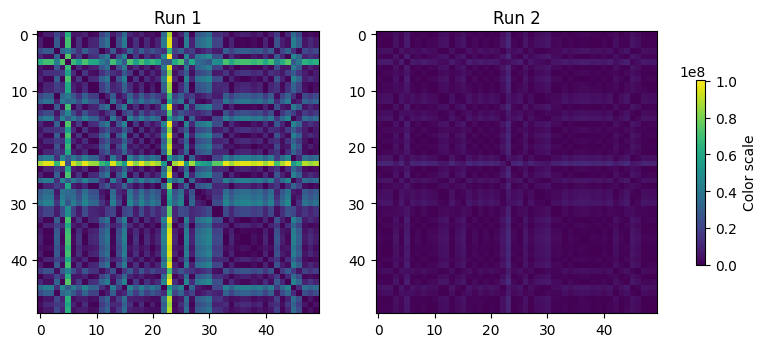

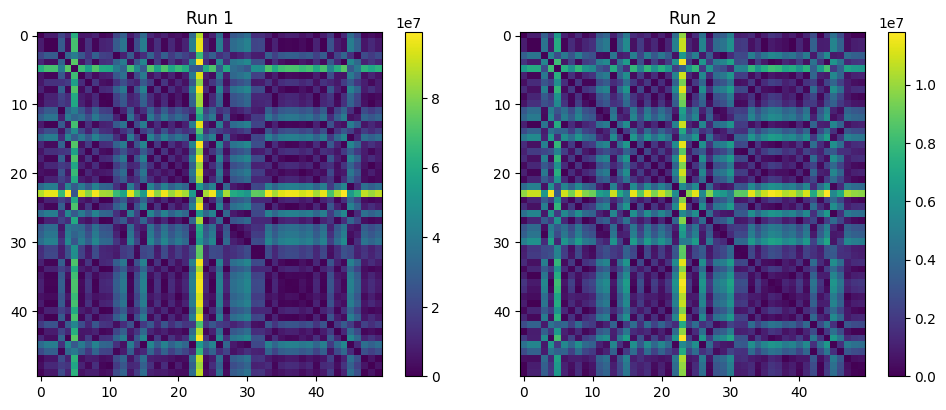

In [3]:
L1_run1 = cdist(hom_counts_list_run1, hom_counts_list_run1, metric='cityblock')
L1_run2 = cdist(hom_counts_list_run2, hom_counts_list_run2, metric='cityblock')
plot_matrix_runs(L1_run1, L1_run2, num_elements=50) # We can see some inconsitent scales among different runs
plot_matrix_runs_different_scale(L1_run1, L1_run2, num_elements=50)

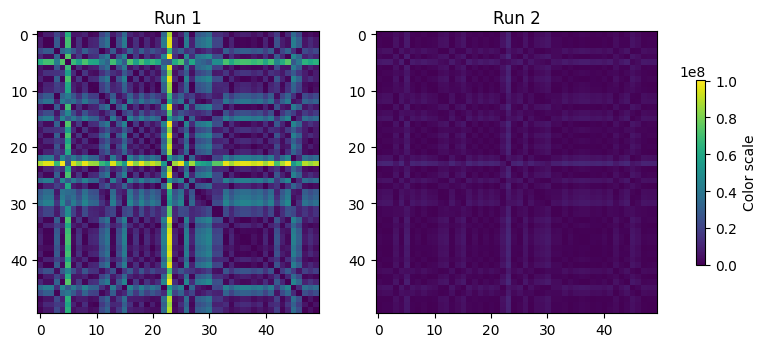

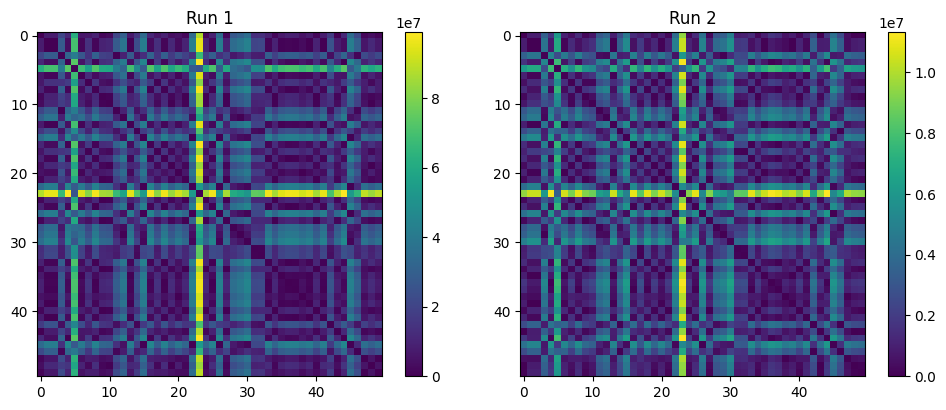

In [4]:
L2_run1 = cdist(hom_counts_list_run1, hom_counts_list_run1, metric='euclidean')
L2_run2 = cdist(hom_counts_list_run2, hom_counts_list_run2, metric='euclidean')
plot_matrix_runs(L2_run1, L2_run2, num_elements=50) # We can see some inconsitent scales among different runs
plot_matrix_runs_different_scale(L2_run1, L2_run2, num_elements=50) # We can see some inconsitent scales among different runs

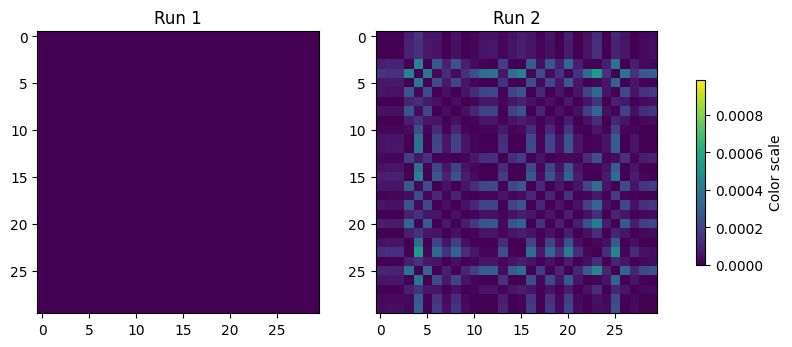

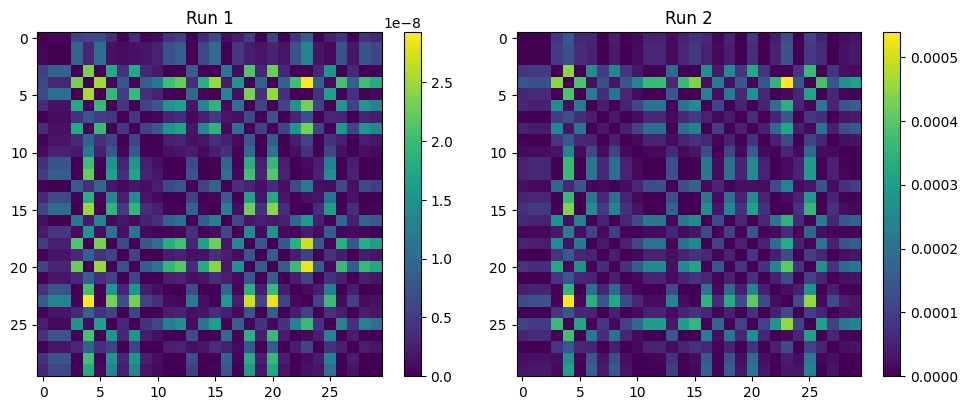

In [5]:
cosine_run1 = cdist(hom_counts_list_run1, hom_counts_list_run1, metric='cosine')
cosine_run2 = cdist(hom_counts_list_run2, hom_counts_list_run2, metric='cosine')
plot_matrix_runs(cosine_run1, cosine_run2, num_elements=30) # We can see some inconsitent scales among different runs
plot_matrix_runs_different_scale(cosine_run1, cosine_run2, num_elements=30) # We can see some inconsitent scales among different runs

Some comments on these:
- Regardless of the metrics it appears that the scale of the results is much different depending on the run considered. Ideally I expect that we would like the results to be more or less run-independent.
    - This may be due to the fact that only 20 homomorphisms are considered.
- Another thing to note is that many counts are 0 
    - This is probably caused by the facts that the MUTAG dataset contains relatively small graphs (on average 17.9 nodes), and so many patterns contain multiple 0s.

In [6]:
vertices = [data_run1['data'][i]['vertices'] for i in range(len(data_run1['data']))]
print(f"The smallest graph has {min(vertices)} nodes\nThe largest graph has {max(vertices)} nodes\nOn average there are {round(sum(vertices)/len(data_run1['data']), 1)} nodes")

The smallest graph has 10 nodes
The largest graph has 28 nodes
On average there are 17.9 nodes


In [7]:
print(f"For the first run the patterns had average size {sum(data_run1['pattern_sizes'])/20}:\n\t{data_run1['pattern_sizes']},")
print(f"For the second run the patterns had average size {sum(data_run2['pattern_sizes'])/20}:\n\t{data_run2['pattern_sizes']}")

For the first run the patterns had average size 7.4:
	[1, 2, 3, 3, 5, 13, 6, 5, 14, 10, 6, 7, 5, 5, 15, 5, 14, 13, 5, 11],
For the second run the patterns had average size 9.65:
	[1, 2, 3, 3, 6, 18, 16, 9, 10, 15, 8, 13, 14, 7, 6, 6, 11, 20, 10, 15]


Ideas to help with the scale problem:
- I would not modify the count vectors -> Not sure of how the theoretical properties would hold.
- Small patterns will have more weight than the largest ones if we use L1 or L2 -> For this we could use homomorphism densities instead of counts.

## Consider count densities instead

In [16]:
# Consider counts densities instead
vertices = vertices
pattern_sizes1 = data_run1['pattern_sizes']
pattern_sizes2 = data_run2['pattern_sizes']

In [17]:
for i in range(len(data_run1['data'])):
    n_vertices = vertices[i]
    den = [n_vertices**pattern_sizes1[j] for j in range(len(pattern_sizes1))]
    data_run1['data'][i]['scaled_counts'] = [data_run1['data'][i]['counts'][j] / den[j] for j in range(len(pattern_sizes1))]

In [18]:
for i in range(len(data_run2['data'])):
    n_vertices = vertices[i]
    den = [n_vertices**pattern_sizes2[j] for j in range(len(pattern_sizes2))]
    data_run2['data'][i]['scaled_counts'] = [data_run2['data'][i]['counts'][j] / den[j] for j in range(len(pattern_sizes2))]

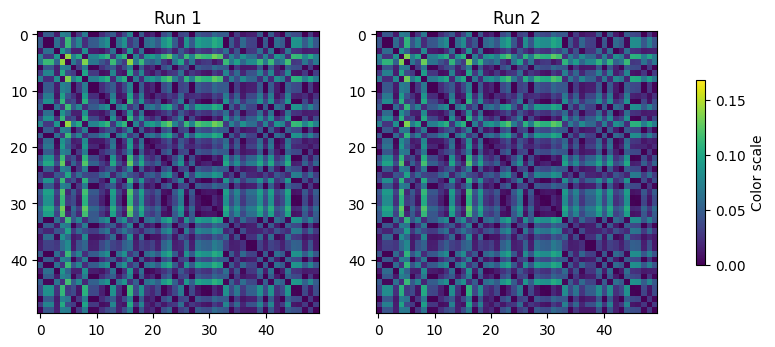

In [19]:
# Try the scaled ones
hom_counts_list_run1_counts_density = np.array([element['scaled_counts'] for element in data_run1['data']], dtype = 'float')
hom_counts_list_run2_counts_density = np.array([element['scaled_counts'] for element in data_run2['data']], dtype = 'float')

L1_run1_counts_density = cdist(hom_counts_list_run1_counts_density, hom_counts_list_run1_counts_density, metric='cityblock')
L1_run2_counts_density = cdist(hom_counts_list_run2_counts_density, hom_counts_list_run2_counts_density, metric='cityblock')
plot_matrix_runs(L1_run1_counts_density, L1_run2_counts_density, num_elements=50)

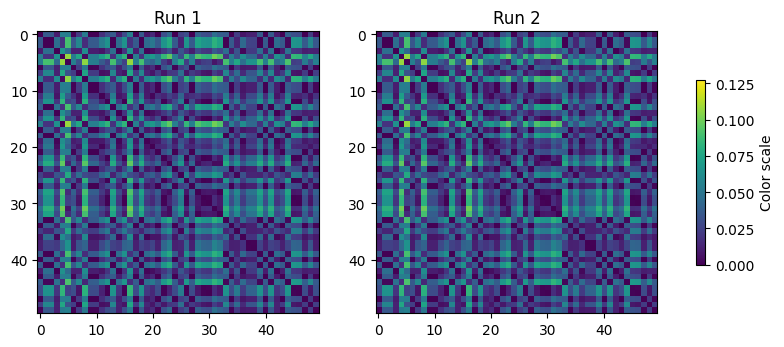

In [20]:
L2_run1_counts_density = cdist(hom_counts_list_run1_counts_density, hom_counts_list_run1_counts_density, metric='euclidean')
L2_run2_counts_density = cdist(hom_counts_list_run2_counts_density, hom_counts_list_run2_counts_density, metric='euclidean')
plot_matrix_runs(L2_run1_counts_density, L2_run2_counts_density, num_elements=50)

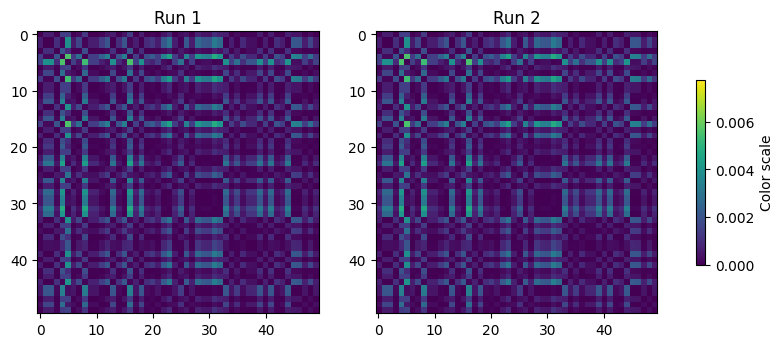

In [21]:
cosine_run1_counts_density = cdist(hom_counts_list_run1_counts_density, hom_counts_list_run1_counts_density, metric='cosine')
cosine_run2_counts_density = cdist(hom_counts_list_run2_counts_density, hom_counts_list_run2_counts_density, metric='cosine')
plot_matrix_runs(cosine_run1_counts_density, cosine_run2_counts_density, num_elements=50)

Some considerations now, where p is the number of homomorphism counts:
- If we use $L_2$ the distance between any two graphs is in $[0, \sqrt{p}]$ -> Divide by $\sqrt{p}$ to make it in $[0, 1]$ and independent of the number of homomorphism counts chosen.
- If we use $L_2$ the distance between any two graphs is in $[0, p]$ -> Divide by $p$ to make it in $[0, 1]$ and independent of the number of homomorphism counts chosen.

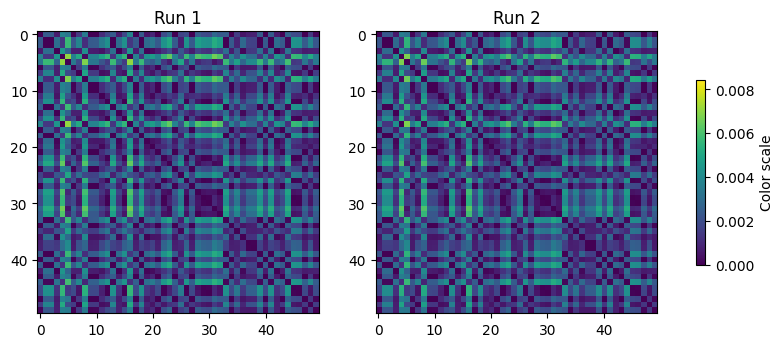

In [26]:
# Try the scaled ones
p = len(data_run1['pattern_sizes'])

L1_run1_scaled_counts_len = cdist(hom_counts_list_run1_counts_density, hom_counts_list_run1_counts_density, metric='cityblock')/(p)
L1_run2_scaled_counts_len = cdist(hom_counts_list_run2_counts_density, hom_counts_list_run2_counts_density, metric='cityblock')/(p)
plot_matrix_runs(L1_run1_scaled_counts_len, L1_run2_scaled_counts_len, num_elements=50) 

## Cosine distance analysis

In [30]:
zero_columns1 = np.all(hom_counts_list_run1 == 0, axis=0)
zero_columns_count = np.sum(zero_columns1)
print("Run1: Number of columns where all entries are 0:", zero_columns_count) # We have that 15 out of 20 columns contain all 0s

zero_columns2 = np.all(hom_counts_list_run2 == 0, axis=0)
zero_columns_count = np.sum(zero_columns2)
print("Run2: Number of columns where all entries are 0:", zero_columns_count) # We have that 15 out of 20 columns contain all 0s

Run1: Number of columns where all entries are 0: 15
Run2: Number of columns where all entries are 0: 13


# y value using the difference metrics

In [45]:
print(f"For L1 the maximum is:\n\tFor counts: {np.max(L1_run1)}\n\tFor counts densities: {np.max(L1_run1_counts_density)}")
print(f"For L2 the maximum is:\n\tFor counts: {np.max(L2_run1)}\n\tFor counts densities: {np.max(L2_run1_counts_density)}")
print(f"For cosine the maximum is:\n\tFor counts: {np.max(cosine_run1)}\n\tFor counts densities: {np.max(cosine_run1_counts_density)}")

For L1 the maximum is:
	For counts: 100397542.0
	For counts densities: 0.1683516769136183
For L2 the maximum is:
	For counts: 100386921.54212691
	For counts densities: 0.12728462091597986
For cosine the maximum is:
	For counts: 9.217446628184689e-08
	For counts densities: 0.007756533913161334
